In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Add, Concatenate, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras import backend as K
from scipy.signal import stft
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import pickle as pkl

from utils import Person, analyze

os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
/Users/enea/anaconda3/envs/dvsemg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/enea/anaconda3/envs/dvsemg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/enea/anaconda3/envs/dvsemg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/enea/anaconda3/e

In [2]:
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}
classes_inv = {v: k for k, v in classes_dict.items()}

# LOAD IMAGES

In [3]:
# Load image dataset
crop_path = './dump/img_cropped/'
all_frames = [i for i in sorted(os.listdir(crop_path)) if 'tiff' in i]
Y_IMG = np.array([classes_dict[i.split('_')[2]] for i in sorted(os.listdir(crop_path)) if 'tiff' in i])
SUB_IMG = np.array([int(i[7:9]) for i in sorted(os.listdir(crop_path)) if 'tiff' in i])
SES_IMG = np.array([int(i[17:19]) for i in sorted(os.listdir(crop_path)) if 'tiff' in i])
TRI_IMG = np.array([int(i.split('_')[3]) for i in sorted(os.listdir(crop_path)) if 'tiff' in i])
IDX_IMG = np.array([int(i.split('_')[4].split('.')[0]) for i in sorted(os.listdir(crop_path)) if 'tiff' in i])

IDX_IMG = np.array(IDX_IMG)
Y_IMG = np.array(Y_IMG)
SUB_IMG = np.array(SUB_IMG)
SES_IMG = np.array(SES_IMG)
TRI_IMG = np.array(TRI_IMG)

print(len(IDX_IMG))
print(Y_IMG.shape)
print(list(set(SUB_IMG)))
print(list(set(SES_IMG)))
print(list(set(TRI_IMG)))
print(list(set(IDX_IMG)))

47745
(47745,)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [4]:
X_IMG = np.array([plt.imread(crop_path + f)[::-1] for f in all_frames])
X_IMG = np.array(X_IMG)
print(X_IMG.shape)

(47745, 40, 40, 3)


In [6]:
# CORRECTION DICTIONARY for synchronization and allignment 
corrections = {}
corrections['subject01_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-15, 'cy':20}
corrections['subject01_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':0}
corrections['subject01_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':10}
corrections['subject02_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-40, 'cy':5}
corrections['subject02_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':5}

corrections['subject03_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject03_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject03_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject04_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-30, 'cy':-15}
corrections['subject04_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-50, 'cy':-10}
corrections['subject04_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-40, 'cy':-10}
corrections['subject05_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':-10}
corrections['subject05_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':10, 'cy':-10}
corrections['subject05_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':-10}
corrections['subject06_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':0}
corrections['subject06_session02'] = {'fs':197, 'tg':'base', 'shift':1.0, 'cx':5, 'cy':-5}
corrections['subject06_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject07_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject07_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject07_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':0}
corrections['subject08_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-20, 'cy':10}
corrections['subject08_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject08_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':20, 'cy':0}
corrections['subject09_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}

corrections['subject09_session02'] = {'fs':185, 'tg':'base', 'shift':2.0, 'cx':-10, 'cy':-10}

corrections['subject09_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':-20}
corrections['subject10_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject10_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject10_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}

corrections['subject11_session01'] = {'fs':174, 'tg':'base', 'shift':-4, 'cx':-5, 'cy':10}
corrections['subject11_session02'] = {'fs':169, 'tg':'base', 'shift':-3, 'cx':-5, 'cy':15}
corrections['subject11_session03'] = {'fs':173, 'tg':'base', 'shift':-3.5, 'cx':-8, 'cy':10}
corrections['subject12_session01'] = {'fs':200, 'tg':'base', 'shift':-2, 'cx':0, 'cy':10}
corrections['subject12_session02'] = {'fs':200, 'tg':'base', 'shift':-2.5, 'cx':0, 'cy':10}
corrections['subject12_session03'] = {'fs':200, 'tg':'base', 'shift':-2.5, 'cx':0, 'cy':10}
corrections['subject13_session01'] = {'fs':200, 'tg':'single', 'shift':-0.5, 'cx':-10, 'cy':20}
corrections['subject13_session02'] = {'fs':200, 'tg':'base', 'shift':-3, 'cx':5, 'cy':15}
corrections['subject13_session03'] = {'fs':200, 'tg':'base', 'shift':0, 'cx':0, 'cy':10}
corrections['subject14_session01'] = {'fs':200, 'tg':'base', 'shift':-2, 'cx':0, 'cy':5}
corrections['subject14_session02'] = {'fs':200, 'tg':'base', 'shift':-2.5, 'cx':0, 'cy':5}
corrections['subject14_session03'] = {'fs':200, 'tg':'base', 'shift':-2.5, 'cx':0, 'cy':8}
corrections['subject15_session01'] = {'fs':200, 'tg':'base', 'shift':-2.5, 'cx':-5, 'cy':15}
corrections['subject15_session02'] = {'fs':200, 'tg':'base', 'shift':-1.5, 'cx':0, 'cy':15}
corrections['subject15_session03'] = {'fs':200, 'tg':'base', 'shift':-2.5, 'cx':-5, 'cy':15}
corrections['subject16_session01'] = {'fs':200, 'tg':'base', 'shift':-1, 'cx':-10, 'cy':15}
corrections['subject16_session02'] = {'fs':200, 'tg':'base', 'shift':-2, 'cx':-15, 'cy':15}
corrections['subject16_session03'] = {'fs':200, 'tg':'base', 'shift':-2, 'cx':-20, 'cy':15}

corrections['subject17_session01'] = {'fs':200, 'tg':'base', 'shift':-3, 'cx':7, 'cy':10}
corrections['subject17_session02'] = {'fs':200, 'tg':'first', 'shift':-3, 'cx':10, 'cy':10}
corrections['subject17_session03'] = {'fs':200, 'tg':'base', 'shift':-3.2, 'cx':15, 'cy':15}
corrections['subject18_session01'] = {'fs':200, 'tg':'base', 'shift':-4.3, 'cx':-3, 'cy':-5}
corrections['subject18_session02'] = {'fs':200, 'tg':'base', 'shift':-3.2, 'cx':-10, 'cy':-15}
corrections['subject18_session03'] = {'fs':200, 'tg':'base', 'shift':-4.3, 'cx':-10, 'cy':-5}
corrections['subject19_session01'] = {'fs':167, 'tg':'base', 'shift':-2, 'cx':0, 'cy':20}
corrections['subject19_session02'] = {'fs':173, 'tg':'base', 'shift':-2.5, 'cx':-3, 'cy':15}
corrections['subject19_session03'] = {'fs':200, 'tg':'base', 'shift':-2, 'cx':-3, 'cy':15}
corrections['subject20_session01'] = {'fs':174, 'tg':'base', 'shift':-2.6, 'cx':-10, 'cy':10}
corrections['subject20_session02'] = {'fs':176, 'tg':'base', 'shift':-3.5, 'cx':-5, 'cy':0}
corrections['subject20_session03'] = {'fs':174, 'tg':'base', 'shift':-4, 'cx':-5, 'cy':5}

corrections['subject21_session01'] = {'fs':200, 'tg':'base', 'shift':-3, 'cx':0, 'cy':0}
corrections['subject21_session02'] = {'fs':200, 'tg':'base', 'shift':-3.5, 'cx':2, 'cy':-2}
corrections['subject21_session03'] = {'fs':200, 'tg':'base', 'shift':-2.8, 'cx':5, 'cy':5}

corrections['subject02_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-3, 'cy':0}

# LOAD EMG

In [7]:
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/EMG/'
VERBOSE = False
subjects = {}
names = sorted([name for name in os.listdir(data_dir) if "emg" in name])
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])

    subjects["_".join(name.split("_")[:2])] = Person(name.split("_")[0], _emg, _ann, classes=classes)

    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format("_".join(name.split("_")[:2]), _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Data Loaded! 63 Sessions
Done sorting trials!


In [8]:
X_EMG = []
Y_EMG = []
SUB_EMG = []
SES_EMG = []
TRI_EMG = []

for name, data in subjects.items():
    for gesture in classes:
        for trial in range(5):
            X_EMG.append(data.trials[gesture][trial])
            Y_EMG.append(classes_dict[gesture])
            SUB_EMG.append(int(name[7:9]))
            SES_EMG.append(int(name[17:19]))
            TRI_EMG.append(trial)

X_EMG = np.array(X_EMG)
Y_EMG = np.array(Y_EMG)
SUB_EMG = np.array(SUB_EMG)
SES_EMG = np.array(SES_EMG)
TRI_EMG = np.array(TRI_EMG)
print(len(X_EMG))
print(len(Y_EMG))
print(list(set(Y_EMG)))
print(list(set(SUB_EMG)))
print(list(set(SES_EMG)))
print(list(set(TRI_EMG)))

1575
1575
[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[1, 2, 3]
[0, 1, 2, 3, 4]


In [32]:
frame_len = 0.2
frame_step = 0.1
F_SUB = []
F_SESS = []
F_Y = []
F_IMG = []
F_EMG = []

# CREATE ACTUAL DATASET
for subject in range(1, 22):
    for session in range(1, 4):
        for gesture in range(5):
            for trial in range(5):
                
                fs = corrections['subject{:02}_session0{}'.format(subject, session)]['fs']
                
                idx_emg = np.logical_and.reduce([SUB_EMG == subject, 
                                                 SES_EMG == session, 
                                                 TRI_EMG == trial, 
                                                 Y_EMG == gesture])
                idx_img = np.logical_and.reduce([SUB_IMG == subject, 
                                                 SES_IMG == session, 
                                                 TRI_IMG == trial, 
                                                 Y_IMG == gesture])
                
                e = X_EMG[idx_emg][0]
                f = X_IMG[idx_img]
                
                mav = analyze(e, frame_len=0.2, frame_step=0.1, feat='MAV', preprocess=False)
                rms = analyze(e, frame_len=0.2, frame_step=0.1, feat='RMS', preprocess=False)
                a = np.concatenate([mav, rms], 1)
                
                mapping = np.arange(len(a)) * len(f) // len(a)
                F_EMG.append(a)
                F_IMG.append(np.stack(f[mapping]))
                F_SUB.append(np.ones((len(mapping))) * subject)
                F_SESS.append(np.ones((len(mapping))) * session)
                F_Y.append(np.ones((len(mapping))) * gesture)

F_EMG = np.vstack(F_EMG)
F_IMG = np.vstack(F_IMG)
F_SUB = np.hstack(F_SUB)
F_SESS = np.hstack(F_SESS)
F_Y = np.hstack(F_Y)

print(F_EMG.shape)
print(F_IMG.shape)
print(F_SUB.shape)
print(F_SESS.shape)
print(F_Y.shape)

(28782, 16)
(28782, 40, 40, 3)
(28782,)
(28782,)
(28782,)


In [ ]:
print(subject)
print(session)
print(gesture)
print(trial)

In [141]:
test_ses = 1

x_emg_train = F_EMG[F_SESS != test_ses].astype('float32')
x_emg_test = F_EMG[F_SESS == test_ses].astype('float32')

x_img_train = F_IMG[F_SESS != test_ses].astype('float32')
x_img_test = F_IMG[F_SESS == test_ses].astype('float32')

y_train = F_Y[F_SESS != test_ses]
y_test = F_Y[F_SESS == test_ses]

y_train = keras.utils.to_categorical(y_train, 5)
y_test = keras.utils.to_categorical(y_test, 5)

print(x_emg_train.shape)
print(x_img_train.shape)
print(y_train.shape)
print(x_emg_test.shape)
print(x_img_test.shape)
print(y_test.shape)

(19220, 16)
(19220, 40, 40, 3)
(19220, 5)
(9562, 16)
(9562, 40, 40, 3)
(9562, 5)


In [142]:
##### img preprocessing
# normalize
data_max = np.max(x_img_train)
data_min = np.min(x_img_train)
for i in range(len(x_img_train)):
    x_img_train[i] = (x_img_train[i] - data_min) / (data_max - data_min)
for i in range(len(x_img_test)):
    x_img_test[i] = (x_img_test[i] - data_min) / (data_max - data_min)
print("img_min = ", data_min)
print("img_max = ", data_max)

# standardize
data_mean = np.mean(x_img_train)
data_std = np.std(x_img_train) + 1e-15
x_img_train -= data_mean
x_img_train /= data_std
x_img_test -= data_mean
x_img_test /= data_std
print("img_mean = ", data_mean)
print("img_std = ", data_std)

# emg preprocessing
# normalize
data_max = np.max(x_emg_train)
data_min = np.min(x_emg_train)
for i in range(len(x_emg_train)):
    x_emg_train[i] = (x_emg_train[i] - data_min) / (data_max - data_min)
for i in range(len(x_emg_test)):
    x_emg_test[i] = (x_emg_test[i] - data_min) / (data_max - data_min)
print("emg_min = ", data_min)
print("emg_max = ", data_max)

# standardize
data_mean = np.mean(x_emg_train)
data_std = np.std(x_emg_train) + 1e-15
x_emg_train -= data_mean
x_emg_train /= data_std
x_emg_test -= data_mean
x_emg_test /= data_std
print("emg_mean = ", data_mean)
print("emg_std = ", data_std)

img_min =  0.0
img_max =  253.0
img_mean =  0.5144386
img_std =  0.26730623841285805
emg_min =  0.0
emg_max =  87.84133
emg_mean =  0.073996924
emg_std =  0.11713933944702248


# BASELINE CNN (SUMIT)

In [124]:
# cnn for img
img_input_shape_s = (40, 40, 3)
num_classes = 5
# create the cnn model
model_img_s = Sequential()
model_img_s.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=img_input_shape_s))
model_img_s.add(MaxPooling2D(pool_size=(2, 2)))
model_img_s.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_img_s.add(MaxPooling2D(pool_size=(2, 2)))
model_img_s.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_img_s.add(Dropout(0.25))
model_img_s.add(Flatten())
model_img_s.add(Dense(512, activation='relu'))
model_img_s.add(Dropout(0.5))
model_img_s.add(Dense(num_classes, activation='softmax'))
                    
model_img_s.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 38, 38, 8)         224       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 19, 19, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 17, 17, 16)        1168      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 6, 6, 32)          4640      
_________________________________________________________________
dropout_18 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)            

In [125]:
# compile model
model_img_s.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# fit the model
model_img_s.fit(x_img_train, y_train,
        batch_size=32,
        epochs=10,
        verbose=1,
        validation_data=(x_img_test, y_test))

# evaluate the model
scores = model_img_s.evaluate(x_img_test, y_test, verbose=1)
print("%s: %.2f%%" % (model_img_s.metrics_names[1], scores[1]*100))

Train on 19220 samples, validate on 9562 samples
Epoch 1/10
19220/19220 [==============================] - 25s 1ms/step - loss: 0.5347 - accuracy: 0.7971 - val_loss: 0.2184 - val_accuracy: 0.9450
Epoch 2/10
19220/19220 [==============================] - 23s 1ms/step - loss: 0.1312 - accuracy: 0.9614 - val_loss: 0.2017 - val_accuracy: 0.9531
Epoch 3/10
19220/19220 [==============================] - 24s 1ms/step - loss: 0.0895 - accuracy: 0.9726 - val_loss: 0.2123 - val_accuracy: 0.9527
Epoch 4/10
19220/19220 [==============================] - 24s 1ms/step - loss: 0.0701 - accuracy: 0.9788 - val_loss: 0.2253 - val_accuracy: 0.9547
Epoch 5/10
19220/19220 [==============================] - 22s 1ms/step - loss: 0.0562 - accuracy: 0.9824 - val_loss: 0.3402 - val_accuracy: 0.9282
Epoch 6/10
19220/19220 [==============================] - 22s 1ms/step - loss: 0.0524 - accuracy: 0.9845 - val_loss: 0.2128 - val_accuracy: 0.9562
Epoch 7/10
19220/19220 [==============================] - 21s 1ms/ste

In [126]:
# mlp for emg
img_input_shape_s = (16,)
# create the cnn model
model_emg_s = Sequential()
model_emg_s.add(Dense(128, activation='relu', input_shape=img_input_shape_s))
model_emg_s.add(Dropout(0.5))
model_emg_s.add(Dense(128, activation='relu'))
model_emg_s.add(Dense(num_classes, activation='softmax'))

model_emg_s.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 128)               2176      
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 645       
Total params: 19,333
Trainable params: 19,333
Non-trainable params: 0
_________________________________________________________________


In [127]:
# compile model
model_emg_s.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

# fit the model
model_emg_s.fit(x_emg_train, y_train,
        batch_size=32,
        epochs=30,
        verbose=1,
        validation_data=(x_emg_test, y_test))

# evaluate the model
scores = model_emg_s.evaluate(x_emg_test, y_test, verbose=0)
print("%s: %.2f%%" % (model_emg_s.metrics_names[1], scores[1]*100))

Train on 19220 samples, validate on 9562 samples
Epoch 1/30
19220/19220 [==============================] - 2s 111us/step - loss: 1.1700 - accuracy: 0.5024 - val_loss: 1.0373 - val_accuracy: 0.5854
Epoch 2/30
19220/19220 [==============================] - 2s 80us/step - loss: 0.9496 - accuracy: 0.6002 - val_loss: 0.9986 - val_accuracy: 0.6171
Epoch 3/30
19220/19220 [==============================] - 2s 80us/step - loss: 0.8842 - accuracy: 0.6315 - val_loss: 0.9952 - val_accuracy: 0.6108
Epoch 4/30
19220/19220 [==============================] - 2s 84us/step - loss: 0.8471 - accuracy: 0.6473 - val_loss: 0.9850 - val_accuracy: 0.6190
Epoch 5/30
19220/19220 [==============================] - 2s 80us/step - loss: 0.8159 - accuracy: 0.6642 - val_loss: 0.9839 - val_accuracy: 0.6112
Epoch 6/30
19220/19220 [==============================] - 2s 89us/step - loss: 0.7934 - accuracy: 0.6732 - val_loss: 0.9833 - val_accuracy: 0.6222
Epoch 7/30
19220/19220 [==============================] - 2s 89us/st

In [128]:
mergedOut_s = Concatenate()([model_img_s.output, model_emg_s.output])
mergedOut_s = Dense(5, activation='softmax')(mergedOut_s)
model_fus_s = Model([model_img_s.input, model_emg_s.input], mergedOut_s)
model_fus_s.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_16_input (InputLayer)    (None, 40, 40, 3)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 38, 38, 8)    224         conv2d_16_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 19, 19, 8)    0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 17, 17, 16)   1168        max_pooling2d_11[0][0]           
____________________________________________________________________________________________

In [129]:
# freeze the layers except the last dense
for layer in model_fus_s.layers[:len(model_fus_s.layers)-1]:
    layer.trainable = False

# check the status of the layers
for layer in model_fus_s.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x147e0f898> False
<keras.layers.convolutional.Conv2D object at 0x147e0f6a0> False
<keras.layers.pooling.MaxPooling2D object at 0x147e0f710> False
<keras.layers.convolutional.Conv2D object at 0x147e0f908> False
<keras.layers.pooling.MaxPooling2D object at 0x1197ef908> False
<keras.layers.convolutional.Conv2D object at 0x119801668> False
<keras.layers.core.Dropout object at 0x119801748> False
<keras.engine.input_layer.InputLayer object at 0x152023358> False
<keras.layers.core.Flatten object at 0x119820e80> False
<keras.layers.core.Dense object at 0x13ab44160> False
<keras.layers.core.Dense object at 0x119867588> False
<keras.layers.core.Dropout object at 0x147de79b0> False
<keras.layers.core.Dropout object at 0x119867470> False
<keras.layers.core.Dense object at 0x152023ac8> False
<keras.layers.core.Dense object at 0x1198b9e80> False
<keras.layers.core.Dense object at 0x152023128> False
<keras.layers.merge.Concatenate object at 0x14a282048>

In [130]:
# compile model
model_fus_s.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# fit the model
model_fus_s.fit([x_img_train, x_emg_train], y_train,
        batch_size=32,
        epochs=10,
        verbose=1,
        validation_data=([x_img_test, x_emg_test], y_test))

# evaluate the model
scores = model_fus_s.evaluate([x_img_test, x_emg_test], y_test, verbose=1)
print("%s: %.2f%%" % (model_fus_s.metrics_names[1], scores[1]*100))

Train on 19220 samples, validate on 9562 samples
Epoch 1/10
19220/19220 [==============================] - 9s 457us/step - loss: 0.8500 - accuracy: 0.8236 - val_loss: 0.4919 - val_accuracy: 0.9569
Epoch 2/10
19220/19220 [==============================] - 8s 432us/step - loss: 0.2336 - accuracy: 0.9922 - val_loss: 0.2285 - val_accuracy: 0.9624
Epoch 3/10
19220/19220 [==============================] - 8s 436us/step - loss: 0.0878 - accuracy: 0.9934 - val_loss: 0.1636 - val_accuracy: 0.9612
Epoch 4/10
19220/19220 [==============================] - 8s 431us/step - loss: 0.0468 - accuracy: 0.9944 - val_loss: 0.1499 - val_accuracy: 0.9601
Epoch 5/10
19220/19220 [==============================] - 8s 433us/step - loss: 0.0358 - accuracy: 0.9931 - val_loss: 0.1478 - val_accuracy: 0.9601
Epoch 6/10
19220/19220 [==============================] - 8s 436us/step - loss: 0.0309 - accuracy: 0.9930 - val_loss: 0.1488 - val_accuracy: 0.9598
Epoch 7/10
19220/19220 [==============================] - 8s 43

In [131]:
model_emg_s.save('model_emg_s.h5') 
model_img_s.save('model_img_s.h5') 
model_fus_s.save('model_fus_s.h5') 

# BASELINE MLP (CHARLOTTE) [C]

(19220, 40, 40)
(9562, 40, 40)


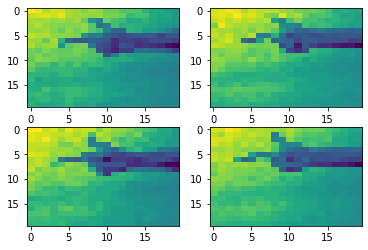

In [167]:
x_img_train_c = np.mean(x_img_train, -1)#.reshape(-1, 1600)
x_img_test_c = np.mean(x_img_test, -1)#.reshape(-1, 1600)
print(x_img_train_c.shape)
print(x_img_test_c.shape)

a = x_img_train_c[:, ::2, ::2]
b = x_img_train_c[:, 1::2, ::2]
c = x_img_train_c[:, ::2, 1::2]
d = x_img_train_c[:, 1::2, 1::2]
idx = 1101
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(a[idx], aspect='auto')
ax[0][1].imshow(b[idx], aspect='auto')
ax[1][0].imshow(c[idx], aspect='auto')
ax[1][1].imshow(d[idx], aspect='auto')


concat_inp_train = [a.reshape(-1, 400), b.reshape(-1, 400), c.reshape(-1, 400), d.reshape(-1, 400)]

a = x_img_test_c[:, ::2, ::2]
b = x_img_test_c[:, 1::2, ::2]
c = x_img_test_c[:, ::2, 1::2]
d = x_img_test_c[:, 1::2, 1::2]

concat_inp_test = [a.reshape(-1, 400), b.reshape(-1, 400), c.reshape(-1, 400), d.reshape(-1, 400)]

In [165]:
# mlp for img
img_input_shape_c = (400,)
models = []

for i in range(4):
    # create the mlp model
    model_img_c = Sequential()
    model_img_c.add(Dense(210, activation='relu', input_shape=img_input_shape_c))
    model_img_c.add(Dropout(0.3))
    model_img_c.add(Dense(5, activation='softmax'))
    models.append(model_img_c)
    print(model_img_c.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 210)               84210     
_________________________________________________________________
dropout_27 (Dropout)         (None, 210)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 5)                 1055      
Total params: 85,265
Trainable params: 85,265
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 210)               84210     
_________________________________________________________________
dropout_28 (Dropout)         (None, 210)               0         
_____________________

In [168]:
# compile model
for inp_train, inp_test, mdl in zip(concat_inp_train, concat_inp_test, models):
    mdl.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

    # fit the model
    mdl.fit(inp, y_train,
            batch_size=32,
            epochs=10,
            verbose=1,
            validation_data=(inp_test, y_test))

    # evaluate the model
    scores = mdl.evaluate(inp_test, y_test, verbose=1)
    print("%s: %.2f%%" % (mdl.metrics_names[1], scores[1]*100))

Train on 19220 samples, validate on 9562 samples
Epoch 1/10
19220/19220 [==============================] - 4s 184us/step - loss: 1.2429 - accuracy: 0.4911 - val_loss: 1.0940 - val_accuracy: 0.5564
Epoch 2/10
19220/19220 [==============================] - 3s 142us/step - loss: 0.8499 - accuracy: 0.6856 - val_loss: 0.8219 - val_accuracy: 0.7199
Epoch 3/10
19220/19220 [==============================] - 3s 160us/step - loss: 0.6482 - accuracy: 0.7712 - val_loss: 0.7400 - val_accuracy: 0.7345
Epoch 4/10
19220/19220 [==============================] - 3s 145us/step - loss: 0.5235 - accuracy: 0.8256 - val_loss: 0.7274 - val_accuracy: 0.7461
Epoch 5/10
19220/19220 [==============================] - 2s 128us/step - loss: 0.4431 - accuracy: 0.8562 - val_loss: 0.6192 - val_accuracy: 0.7862
Epoch 6/10
19220/19220 [==============================] - 3s 140us/step - loss: 0.3829 - accuracy: 0.8795 - val_loss: 0.7101 - val_accuracy: 0.7608
Epoch 7/10
19220/19220 [==============================] - 3s 13

In [171]:
all_scores = []
for inp_test, mdl in zip(concat_inp_test, models):
    # evaluate the model
    all_scores.append(mdl.predict(inp_test))
    print(all_scores[-1].shape)
    

(9562, 5)
(9562, 5)
(9562, 5)
(9562, 5)


In [177]:
final = np.argmax(sum(all_scores), -1)
print(final.shape)
final_y = np.argmax(y_test, -1)
print(final_y.shape)

print(np.sum(np.float32((final_y - final) == 0)) / len(final_y) * 100)

(9562,)
(9562,)
82.26312486927421


In [185]:
from scipy.stats import mode
final = [np.argmax(x, -1) for x in all_scores]
final = mode(np.array(final), 0)[0][0]
print(final)
final_y = np.argmax(y_test, -1)
print(final_y.shape)

print(np.sum(np.float32((final_y - final) == 0)) / len(final_y) * 100)

[0 0 0 ... 4 4 4]
(9562,)
82.1167119849404


In [169]:
# mlp for emg
img_input_shape_c = (16,)
# create the cnn model
model_emg_c = Sequential()
model_emg_c.add(Dense(230, activation='relu', input_shape=img_input_shape_c))
model_emg_c.add(Dense(num_classes, activation='softmax'))

model_emg_c.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 230)               3910      
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 1155      
Total params: 5,065
Trainable params: 5,065
Non-trainable params: 0
_________________________________________________________________


In [170]:
# compile model
model_emg_c.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# fit the model
model_emg_c.fit(x_emg_train, y_train,
        batch_size=32,
        epochs=30,
        verbose=1,
        validation_data=(x_emg_test, y_test))

# evaluate the model
scores = model_emg_c.evaluate(x_emg_test, y_test, verbose=0)
print("%s: %.2f%%" % (model_emg_c.metrics_names[1], scores[1]*100))

Train on 19220 samples, validate on 9562 samples
Epoch 1/30
19220/19220 [==============================] - 2s 117us/step - loss: 1.0877 - accuracy: 0.5579 - val_loss: 1.0541 - val_accuracy: 0.5734
Epoch 2/30
19220/19220 [==============================] - 2s 82us/step - loss: 0.8938 - accuracy: 0.6338 - val_loss: 1.0165 - val_accuracy: 0.5963
Epoch 3/30
19220/19220 [==============================] - 2s 82us/step - loss: 0.8309 - accuracy: 0.6608 - val_loss: 0.9876 - val_accuracy: 0.6079
Epoch 4/30
19220/19220 [==============================] - 2s 81us/step - loss: 0.7874 - accuracy: 0.6798 - val_loss: 0.9872 - val_accuracy: 0.6071
Epoch 5/30
19220/19220 [==============================] - 2s 99us/step - loss: 0.7552 - accuracy: 0.6952 - val_loss: 1.0048 - val_accuracy: 0.6063
Epoch 6/30
19220/19220 [==============================] - 2s 83us/step - loss: 0.7293 - accuracy: 0.7037 - val_loss: 0.9943 - val_accuracy: 0.6155
Epoch 7/30
19220/19220 [==============================] - 2s 93us/st

In [186]:
mergedOut_c = Concatenate()([a.output for a in models] + [model_emg_c.output])
mergedOut_c = Dense(5, activation='softmax')(mergedOut_c)
model_fus_c = Model([a.input for a in models] + [model_emg_c.input], mergedOut_c)
model_fus_c.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_77_input (InputLayer)     (None, 400)          0                                            
__________________________________________________________________________________________________
dense_79_input (InputLayer)     (None, 400)          0                                            
__________________________________________________________________________________________________
dense_81_input (InputLayer)     (None, 400)          0                                            
__________________________________________________________________________________________________
dense_83_input (InputLayer)     (None, 400)          0                                            
___________________________________________________________________________________________

In [187]:
# freeze the layers except the last dense
for layer in model_fus_c.layers[:len(model_fus_c.layers)-1]:
    layer.trainable = False

# check the status of the layers
for layer in model_fus_c.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x15510a518> False
<keras.engine.input_layer.InputLayer object at 0x155364fd0> False
<keras.engine.input_layer.InputLayer object at 0x15524f5c0> False
<keras.engine.input_layer.InputLayer object at 0x154e14f60> False
<keras.layers.core.Dense object at 0x155187080> False
<keras.layers.core.Dense object at 0x158f78828> False
<keras.layers.core.Dense object at 0x154dbddd8> False
<keras.layers.core.Dense object at 0x15527fc88> False
<keras.engine.input_layer.InputLayer object at 0x154ba78d0> False
<keras.layers.core.Dropout object at 0x15510a780> False
<keras.layers.core.Dropout object at 0x1551d04a8> False
<keras.layers.core.Dropout object at 0x15524f588> False
<keras.layers.core.Dropout object at 0x154d1f438> False
<keras.layers.core.Dense object at 0x155187588> False
<keras.layers.core.Dense object at 0x15510a400> False
<keras.layers.core.Dense object at 0x1551d0ba8> False
<keras.layers.core.Dense object at 0x15524fef0> False
<keras.layers.

In [188]:
# compile model
model_fus_c.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# fit the model
model_fus_c.fit(concat_inp_train + [x_emg_train], y_train,
        batch_size=32,
        epochs=10,
        verbose=1,
        validation_data=(concat_inp_test + [x_emg_test], y_test))

# evaluate the model
scores = model_fus_c.evaluate(concat_inp_test + [x_emg_test], y_test, verbose=1)
print("%s: %.2f%%" % (model_fus_c.metrics_names[1], scores[1]*100))

Train on 19220 samples, validate on 9562 samples
Epoch 1/10
19220/19220 [==============================] - 3s 170us/step - loss: 0.5284 - accuracy: 0.9101 - val_loss: 0.4378 - val_accuracy: 0.8475
Epoch 2/10
19220/19220 [==============================] - 2s 127us/step - loss: 0.1395 - accuracy: 0.9700 - val_loss: 0.4125 - val_accuracy: 0.8524
Epoch 3/10
19220/19220 [==============================] - 3s 131us/step - loss: 0.1001 - accuracy: 0.9734 - val_loss: 0.4096 - val_accuracy: 0.8561
Epoch 4/10
19220/19220 [==============================] - 2s 129us/step - loss: 0.0864 - accuracy: 0.9743 - val_loss: 0.4042 - val_accuracy: 0.8614
Epoch 5/10
19220/19220 [==============================] - 4s 213us/step - loss: 0.0809 - accuracy: 0.9743 - val_loss: 0.3972 - val_accuracy: 0.8658
Epoch 6/10
19220/19220 [==============================] - 3s 165us/step - loss: 0.0765 - accuracy: 0.9760 - val_loss: 0.3946 - val_accuracy: 0.8676
Epoch 7/10
19220/19220 [==============================] - 5s 24

In [189]:
single_img = Concatenate()([a.output for a in models])
single_img = Dense(5, activation='softmax')(single_img)
single_img = Model([a.input for a in models], single_img)
single_img.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_77_input (InputLayer)     (None, 400)          0                                            
__________________________________________________________________________________________________
dense_79_input (InputLayer)     (None, 400)          0                                            
__________________________________________________________________________________________________
dense_81_input (InputLayer)     (None, 400)          0                                            
__________________________________________________________________________________________________
dense_83_input (InputLayer)     (None, 400)          0                                            
___________________________________________________________________________________________

In [190]:
model_emg_c.save('model_emg_c.h5') 
single_img.save('model_img_c.h5') 
model_fus_c.save('model_fus_c.h5') 

# Cortex-A53 (ARMv8)

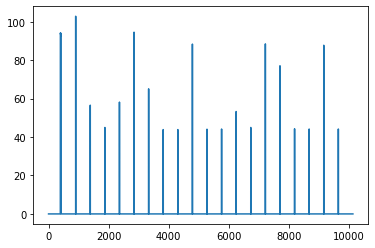

In [101]:
cpu_usages = np.load('/Users/enea/profile_fus_cpu_usage.npy')
plt.plot(cpu_usages[1000:])

In [108]:
print(np.mean(cpu_usages[1000:][cpu_usages[1000:] > 0]))

79.5909090909091


In [107]:
print(cpu_usages[1000:][cpu_usages[1000:] != 0])

[ 83.   94.2  93.8  93.8  93.8  93.8  93.6  93.5  93.5  93.5  93.6  93.6
  93.6  93.6  93.7  92.8  94.1  93.8  93.7  93.6  93.7  93.5  93.5  93.7
  93.7 102.9  56.6  45.   58.2  94.6  65.1  43.9  43.9  88.4  44.1  44.2
  53.3  45.   88.5  77.1  44.3  44.2  87.8  44.2]


In [111]:
import pandas as pd
data = pd.read_csv('./full_results_cross_latency_v1.csv')

print(data.keys())

Index(['model', 'feat', 'frame_len', 'test_ses', 'accuracy'], dtype='object')


In [119]:
print(data[data['frame_len'] == 0.2].groupby(['model', 'feat']).mean())
print(data[data['frame_len'] == 0.2].groupby(['model', 'feat']).std())

                frame_len  test_ses   accuracy
model     feat                                
charlotte emg         0.2         2  65.363757
          fus         0.2         2  82.117099
          img         0.2         2  64.151708
sumit     emg         0.2         2  68.071151
          fus         0.2         2  95.733442
          img         0.2         2  95.197785
                frame_len  test_ses  accuracy
model     feat                               
charlotte emg         0.0       1.0  2.977906
          fus         0.0       1.0  3.142194
          img         0.0       1.0  5.190006
sumit     emg         0.0       1.0  2.848121
          fus         0.0       1.0  1.119447
          img         0.0       1.0  1.329271


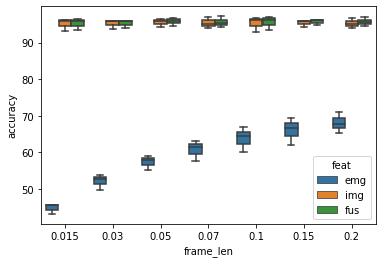

In [115]:
import seaborn as sns

sns.boxplot(data=data[data['model'] == 'sumit'], x='frame_len', y='accuracy', hue='feat')

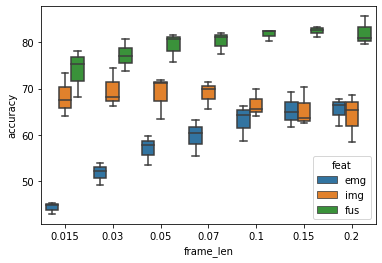

In [117]:
sns.boxplot(data=data[data['model'] == 'charlotte'], x='frame_len', y='accuracy', hue='feat')